### Imports and API setup

In [21]:
import datetime
import json
import os
import dotenv

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from garminconnect import Garmin

# Load environment variables
dotenv.load_dotenv(".env", override=True)
EMAIL = os.getenv("EMAIL")
PASSWORD = os.getenv("PASSWORD")

assert EMAIL is not None, "EMAIL environment variable not defined"
assert PASSWORD is not None, "PASSWORD environment variable not defined"

In [8]:
# Setup API
print("Authenticating...")
api = Garmin(EMAIL, PASSWORD)
api.login()

Authenticating...


True

### Helper Functions

In [9]:
def json_to_file(data, filename: str):
    """Write JSON data to file."""
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)


def json_from_file(filename: str):
    """Load JSON data from file."""
    with open(filename, "r") as f:
        return json.load(f)


def json_to_str(data):
    """Convert JSON data to string."""
    return json.dumps(data, indent=4)


def ms_to_date(ms: int):
    """Convert epoch timestamp in milliseconds to datetime object."""
    return datetime.datetime.fromtimestamp(ms / 1000.0)

### Querying data

In [99]:
# Example selections and settings
TODAY = datetime.date.today()
YESTERDAY = TODAY - datetime.timedelta(days=1)
WEEK_AGO = TODAY - datetime.timedelta(days=7)
MONTH_AGO = TODAY - datetime.timedelta(days=30)
YEAR_AGO = TODAY - datetime.timedelta(days=365)

FOUR_YEARS_AGO = TODAY - datetime.timedelta(days=365*4)

In [11]:
# Get HR data
hr = api.get_heart_rates(YESTERDAY.isoformat())
# print(json_to_str(hr))
json_to_file(hr, "data/hr_example.json")

In [13]:
# Get stress data
stress = api.get_stress_data(YESTERDAY.isoformat())
json_to_file(stress, 'data/stress_example.json')

In [91]:
def save_sleep_data(day: datetime.date):
    day_iso = day.isoformat()
    sleep = api.get_sleep_data(day_iso)
    json_to_file(sleep, 'data/sleep/' + day_iso + '.json')

In [ ]:
i = 0
day = FOUR_YEARS_AGO

while day < YEAR_AGO:
    save_sleep_data(day)

    # Go to next day
    day = day + datetime.timedelta(days=1)
    i = i + 1

    # Print progress
    if i % 10 == 0:
        print(f"Day {i} - {day.isoformat()}")
    

### Data Analysis

In [101]:
# Make sleep dataframe
sleep_list = []

day = FOUR_YEARS_AGO
while day < TODAY:
    sleep_json = json_from_file(f"data/sleep/{day.isoformat()}.json")
    sleep_list.append(sleep_json["dailySleepDTO"])
    day += datetime.timedelta(days=1)

sleep_json_df = pd.DataFrame(sleep_list)

In [102]:
sleep_df = pd.DataFrame()
sleep_df["date"] = pd.to_datetime(sleep_json_df["calendarDate"])
sleep_df["daySinceEpoch"] = (sleep_df["date"] 
                                  - datetime.datetime(1970,1,1)).dt.days

sleep_df["sleepTimeHours"] = sleep_json_df["sleepTimeSeconds"] / 3600
sleep_df["deepSleepHours"] = sleep_json_df["deepSleepSeconds"] / 3600
sleep_df["lightSleepHours"] = sleep_json_df["lightSleepSeconds"] / 3600
sleep_df["remSleepHours"] = sleep_json_df["remSleepSeconds"] / 3600
sleep_df["awakeSleepHours"] = sleep_json_df["awakeSleepSeconds"] / 3600

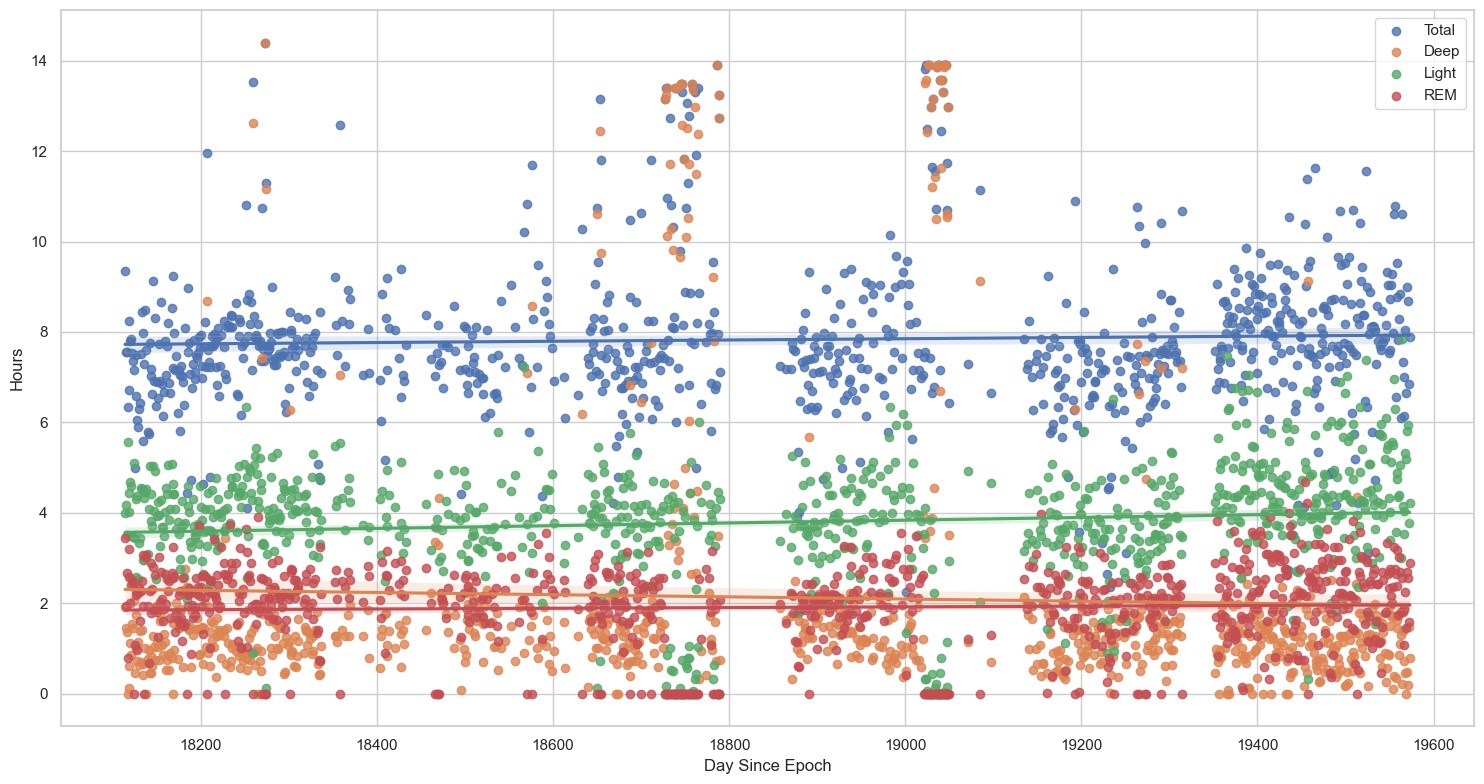

In [113]:
plt.figure(figsize=(15, 8))

sns.set_theme(style="whitegrid")
sns.color_palette("tab10")

sns.regplot(data=sleep_df, x="daySinceEpoch", y="sleepTimeHours", label="Total")
sns.regplot(data=sleep_df, x="daySinceEpoch", y="deepSleepHours", label="Deep")
sns.regplot(data=sleep_df, x="daySinceEpoch", y="lightSleepHours", label="Light")
sns.regplot(data=sleep_df, x="daySinceEpoch", y="remSleepHours", label="REM")

plt.xlabel("Day Since Epoch")
plt.ylabel("Hours")

plt.tight_layout()
plt.legend()
plt.show()